In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import optimize
from scipy import stats
from scipy.special import erfc
from scipy.stats import pareto
from sklearn.model_selection import train_test_split

In [4]:
#data = np.genfromtxt('Pareto.csv', delimiter=',', skip_header=1)
data = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/Pareto.csv", sep=",", header=None)

In [ ]:
n, Size = data.shape
train = data[:int(n*0.8), :]
test = data[int(n*0.8):, :]
test = test[test[:, 0].argsort()]

In [5]:
train_X = train[:, 2:]
train_Y = train[:, 0:2]
test_X = test[:, 2:]
test_Y = test[:, 0:2]

In [5]:
SEED = 42
train_intervals_df, test_intervals_df = train_test_split(data, train_size=0.8, random_state=SEED, shuffle=True)

In [6]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [7]:
train_intervals_X = np.array(train_intervals_df)[:, 2:]
train_intervals_Y = np.array(train_intervals_df)[:, :2]
test_intervals_X = np.array(test_intervals_df)[:, 2:]
test_intervals_Y = np.array(test_intervals_df)[:, :2]
val_intervals_X = np.array(val_intervals_df)[:, 2:]
val_intervals_Y = np.array(val_intervals_df)[:, :2]

### МНК

In [8]:
def estimate_parameters_lsq(sample):
    # Сортировка выборки и вычисление эмпирической ФРС
    sample_sorted = np.sort(sample)
    ecdf = np.arange(1, len(sample) + 1) / len(sample)
    
    def pareto_cdf(x, b, scale):
        return pareto.cdf(x, b, scale=scale)
    
    def error_function(params, x, ecdf_values):
        """
        Функция ошибки – сумма квадратов разностей между
        теоретической ФРС, полученной для параметров b и scale,
        и эмпирической ФРС.
        """
        b, scale = params
        # Ограничения на параметры: параметры должны быть положительны
        if b <= 0 or scale <= 0:
            return 1e10  # штрафное большое значение ошибки
        theoretical_cdf = pareto_cdf(x, b, scale)
        return np.sum((theoretical_cdf - ecdf_values) ** 2)
    
    # Начальные предположения для параметров методом моментов
    sample_mean = np.mean(sample)
    sample_min = np.min(sample)
    
    b_init = 1 / (sample_mean / sample_min - 1)
    scale_init = sample_min
    
    initial_guess = [b_init, scale_init]
    
    # Оптимизация для минимизации функции ошибки
    result = optimize.minimize(
        error_function,
        initial_guess,
        args=(sample_sorted, ecdf),
        bounds=[(1e-10, None), (1e-10, None)]  # b > 0, scale > 0
    )
    
    return result.x

In [10]:
mnk = np.zeros((2000,2))
#mnk = np.zeros((test_Y.shape[0], test_Y.shape[1]))
for i,sample in enumerate(test_intervals_X[:,:]):
    #print(i, sample)
    mnk[i, 0], mnk[i, 1] = estimate_parameters_lsq(sample)

In [11]:
mnk

array([[2.40818316, 0.77121427],
       [2.9430456 , 0.9569917 ],
       [2.26816235, 0.52072679],
       ...,
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [12]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - mnk[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], mnk[:,0])
mse = mean_squared_error(test_Y[:,0], mnk[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], mnk[:,0]))
print("\nxm")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - mnk[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], mnk[:,1])
mse = mean_squared_error(test_Y[:,1], mnk[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], mnk[:,1]))
print("\na")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


xm
MSE: 0.0006995114970732153
RMSE: 0.026448279661883782
R² Score: 0.9961923331728499
MAPE: 0.904632646285906%

a
MSE: 7.832589710265682e-07
RMSE: 0.0008850191924622698
R² Score: 0.9999902260276221
MAPE: 0.1203211938738214%


### Метод моментов

ОГРАНИЧЕНИЕ! E(X) конечено при alpha > 1, а D(X) конечено при alpha > 2 

alpha - параметр формы - data[:,0]

Генерировалось alpha uniform(1.5, 3)
Не знаю почему так хорошо работает, но работает

In [27]:
MM = np.zeros((data[:,0:2].shape))
for i in range(data.shape[0]):
    sample_mean = np.mean(data[i, 2:]) 
    sample_var = np.var(data[i, 2:])
    
    # E[X] = xm * alpha / (alpha - 1) for alpha > 1
    # Var[X] = xm^2 * alpha / ((alpha - 1)^2 * (alpha - 2)) for alpha > 2

    cv = np.sqrt(sample_var) / sample_mean
    
    alpha_estimate = 1 + np.sqrt(1 + (1/(cv**2)))
    
    xm_estimate = sample_mean * (alpha_estimate - 1) / alpha_estimate
    
    alpha_estimate = max(alpha_estimate, 2.1)  # alpha must be > 2 for variance to exist
    xm_estimate = max(xm_estimate, np.min(data[i, 2:]))  # xm must be less than all observations
    
    MM[i][0] = alpha_estimate
    MM[i][1] = xm_estimate


In [25]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((data[:,0] - MM[:,0]) / data[:,0])) * 100
r2 = r2_score(data[:,0], MM[:,0])
mse = mean_squared_error(data[:,0], MM[:,0])
rmse = np.sqrt(mean_squared_error(data[:,0], MM[:,0]))
print("\nMM par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((data[:,1] - MM[:,1]) / data[:,1])) * 100
r2 = r2_score(data[:,1], MM[:,1])
mse = mean_squared_error(data[:,1], MM[:,1])
rmse = np.sqrt(mean_squared_error(data[:,1], MM[:,1]))
print("\nMM par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


MM par 1
MSE: 0.07926943440751287
RMSE: 0.2815482807752746
R² Score: 0.577827160012369
MAPE: 12.051873139902963%

MM par 2
MSE: 0.01000719050987493
RMSE: 0.10003594608876816
R² Score: 0.8755204240522373
MAPE: 11.077788687375925%


In [12]:
train_Y[1]

array([1.75773551, 0.70671532])

### Регрессия на интервалах

In [8]:
pareto_inter = CatBoostRegressor(loss_function='MultiRMSE')
pareto_inter.fit(train_X, train_Y, eval_set = (test_X, test_Y))

KeyboardInterrupt: 

: 

In [6]:
Cat_predictions = pareto_inter.predict(test_X)

In [7]:
pareto_inter.save_model('pareto_inter_model.cbm')

In [8]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nInter par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nInter par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Inter par 1
MSE: 0.056489643482649954
RMSE: 0.23767550038371635
R² Score: 0.6925086400060871
MAPE: 9.28068199764278%

Inter par 2
MSE: 0.0005666670096524027
RMSE: 0.023804768632616505
R² Score: 0.9929287912367442
MAPE: 5.9300376689275405%


### Регрессия на статистиках

In [5]:
stat_M = np.zeros((7999,10)) # Матрицы для записиси статистик наблюдений
test_stat_M = np.zeros((2000,10))

In [6]:
#Далее для каждого наблюдения вычисляются 4 статистики
stat_M[:,0] = np.mean(train_X, axis=1) # Вычисляется среднее 
stat_M[:,1] = np.var(train_X, axis=1) # Вычисляется дисперсию 
stat_M[:,2] = np.std(train_X, axis=1) # Вычисляется стандартное отклонение
stat_M[:,3] =  stat_M[:,2] / stat_M[:,0] # Вычисляется вариацию 

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for i, q in enumerate(quantiles):
    stat_M[:, 4 + i] = np.quantile(train_X, q, axis=1)

In [7]:
test_stat_M[:,0] = np.mean(test_X, axis=1)
test_stat_M[:,1] = np.var(test_X, axis=1)
test_stat_M[:,2] = np.std(test_X, axis=1)
test_stat_M[:,3] =  test_stat_M[:,2] / test_stat_M[:,0]

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for i, q in enumerate(quantiles):
    test_stat_M[:, 4 + i] = np.quantile(test_X, q, axis=1)

In [8]:
pareto_stat = CatBoostRegressor(iterations=10000,
                          learning_rate=0.05,
                          depth=5, loss_function='MultiRMSE')

In [11]:
pareto_stat.fit(stat_M, train_Y, eval_set = (test_stat_M, test_Y))

0:	learn: 0.4982404	test: 0.4931412	best: 0.4931412 (0)	total: 2.13ms	remaining: 21.3s
1:	learn: 0.4783094	test: 0.4732727	best: 0.4732727 (1)	total: 4.32ms	remaining: 21.6s
2:	learn: 0.4595570	test: 0.4545969	best: 0.4545969 (2)	total: 6.36ms	remaining: 21.2s
3:	learn: 0.4423589	test: 0.4373275	best: 0.4373275 (3)	total: 8.38ms	remaining: 20.9s
4:	learn: 0.4263566	test: 0.4213305	best: 0.4213305 (4)	total: 10.6ms	remaining: 21.2s
5:	learn: 0.4098708	test: 0.4048960	best: 0.4048960 (5)	total: 12.8ms	remaining: 21.4s
6:	learn: 0.3947949	test: 0.3899446	best: 0.3899446 (6)	total: 14.2ms	remaining: 20.3s
7:	learn: 0.3798211	test: 0.3750636	best: 0.3750636 (7)	total: 15.7ms	remaining: 19.6s
8:	learn: 0.3661974	test: 0.3615371	best: 0.3615371 (8)	total: 17ms	remaining: 18.9s
9:	learn: 0.3528531	test: 0.3482438	best: 0.3482438 (9)	total: 18.5ms	remaining: 18.5s
10:	learn: 0.3405142	test: 0.3360251	best: 0.3360251 (10)	total: 20ms	remaining: 18.2s
11:	learn: 0.3286979	test: 0.3243387	best: 0.

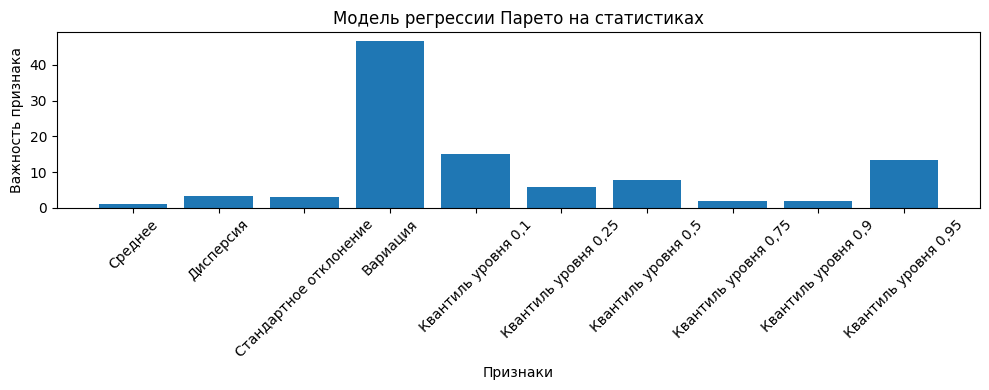

In [15]:
# Define feature names based on the order used in stat_M
feature_names = ["Среднее", "Дисперсия", "Стандартное отклонение", "Вариация", "Квантиль уровня 0,1", "Квантиль уровня 0,25", "Квантиль уровня 0,5", "Квантиль уровня 0,75", "Квантиль уровня 0,9", "Квантиль уровня 0,95"]

# Get feature importances from pareto_stat model
importance = pareto_stat.get_feature_importance()

# Plot the feature importances
plt.figure(figsize=(10, 4))
plt.bar(range(len(importance)), importance, tick_label=feature_names)
plt.xlabel("Признаки")
plt.ylabel("Важность признака")
plt.title("Модель регрессии Парето на статистиках")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
Cat_predictions = pareto_stat.predict(test_stat_M)

In [60]:
pareto_stat.save_model('pareto_stat_model.cbm')

In [62]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nStat par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nStat par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Stat par 1
MSE: 0.0019929487703690737
RMSE: 0.04464245479774912
R² Score: 0.9891517366720999
MAPE: 1.4574208432899496%

Stat par 2
MSE: 1.9995738565099985e-05
RMSE: 0.004471659486711839
R² Score: 0.999750481253786
MAPE: 1.2343654449808565%


### Регрессия на моментах

In [7]:
train_m_X = train_X.copy()
for i in range(train_X.shape[0]):
    for j in range(1, train_X.shape[1]):
        train_m_X[i,j] += train_m_X[i,j-1]

test_m_X = test_X.copy()
for i in range(test_X.shape[0]):
    for j in range(1, test_X.shape[1]):
        test_m_X[i,j] += test_m_X[i,j-1]

In [8]:
pareto_m = CatBoostRegressor(loss_function='MultiRMSE')
pareto_m.fit(train_m_X, train_Y, eval_set = (test_m_X, test_Y))

0:	learn: 0.5127564	test: 0.5075542	best: 0.5075542 (0)	total: 4.58s	remaining: 1h 16m 16s
1:	learn: 0.5072039	test: 0.5018777	best: 0.5018777 (1)	total: 8.36s	remaining: 1h 9m 33s
2:	learn: 0.5019858	test: 0.4964787	best: 0.4964787 (2)	total: 10.8s	remaining: 1h 5s
3:	learn: 0.4971009	test: 0.4914619	best: 0.4914619 (3)	total: 13.8s	remaining: 57m 15s
4:	learn: 0.4923281	test: 0.4865434	best: 0.4865434 (4)	total: 16.3s	remaining: 53m 55s
5:	learn: 0.4876087	test: 0.4816782	best: 0.4816782 (5)	total: 20.3s	remaining: 56m 10s
6:	learn: 0.4832701	test: 0.4771940	best: 0.4771940 (6)	total: 23.8s	remaining: 56m 16s
7:	learn: 0.4788821	test: 0.4727737	best: 0.4727737 (7)	total: 26.3s	remaining: 54m 20s
8:	learn: 0.4744676	test: 0.4682935	best: 0.4682935 (8)	total: 28.7s	remaining: 52m 43s
9:	learn: 0.4707270	test: 0.4644267	best: 0.4644267 (9)	total: 31s	remaining: 51m 10s
10:	learn: 0.4666903	test: 0.4602819	best: 0.4602819 (10)	total: 35s	remaining: 52m 25s
11:	learn: 0.4629785	test: 0.45

In [9]:
Cat_predictions = pareto_m.predict(test_X)

In [10]:
pareto_m.save_model('pareto_moment_model.cbm')

In [11]:
#Оценка качества регрессии первого параметра
mape = np.mean(np.abs((test_Y[:,0] - Cat_predictions[:,0]) / test_Y[:,0])) * 100
r2 = r2_score(test_Y[:,0], Cat_predictions[:,0])
mse = mean_squared_error(test_Y[:,0], Cat_predictions[:,0])
rmse = np.sqrt(mean_squared_error(test_Y[:,0], Cat_predictions[:,0]))
print("\nMoment par 1")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')

#Оценка качества регрессии второго параметра
mape = np.mean(np.abs((test_Y[:,1] - Cat_predictions[:,1]) / test_Y[:,1])) * 100
r2 = r2_score(test_Y[:,1], Cat_predictions[:,1])
mse = mean_squared_error(test_Y[:,1], Cat_predictions[:,1])
rmse = np.sqrt(mean_squared_error(test_Y[:,1], Cat_predictions[:,1]))
print("\nMoment par 2")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
print(f'MAPE: {mape}%')


Moment par 1
MSE: 0.47175017169196926
RMSE: 0.6868407178465538
R² Score: -1.5678884292388657
MAPE: 23.895764416262796%

Moment par 2
MSE: 0.3215796583983789
RMSE: 0.5670799400423002
R² Score: -3.012862686229626
MAPE: 93.33082834795985%
